In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [16]:
link_data = yf.download('LINK-USD', start='1900-01-01')
link_data.dropna(inplace=True)
link_data = link_data[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(link_data)

In [18]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [19]:
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149 - val_loss: 5.2364e-04
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 3.4419e-04
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 6.5411e-04
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 2.9042e-04
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 4.8641e-04
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 2.2803e-04
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 1.8001e-04
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 2.7265e-04
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 2.2685e-04
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 1.5174e-04
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3733e-04 - val_loss: 1.6965e-04
Epoch 12/100
59

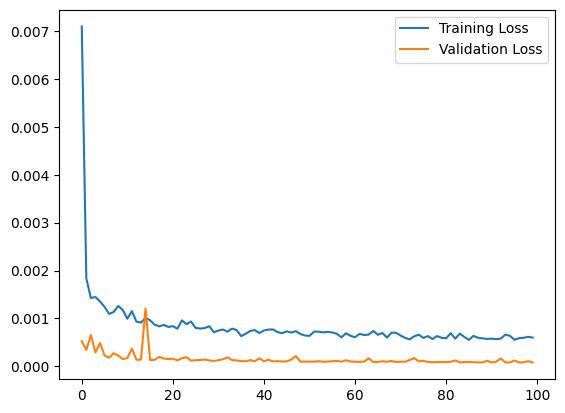

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [22]:
def forecast_future_values(model, X, num_days):
    forecast = []
    current_sequence = X[-seq_length:]
    for _ in range(num_days):
        next_value = model.predict(current_sequence.reshape(1, seq_length, 1))[0][0]
        forecast.append(next_value)
        current_sequence = np.append(current_sequence[1:], next_value)
    return forecast


In [23]:
future_forecast = forecast_future_values(model, X_val[-1], 6)
actual_prices = scaler.inverse_transform(y_val[-6:].reshape(-1, 1))
predicted_prices = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [24]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Inverse transform the scaled predicted prices
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_val_pred_inv = scaler.inverse_transform(y_val_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


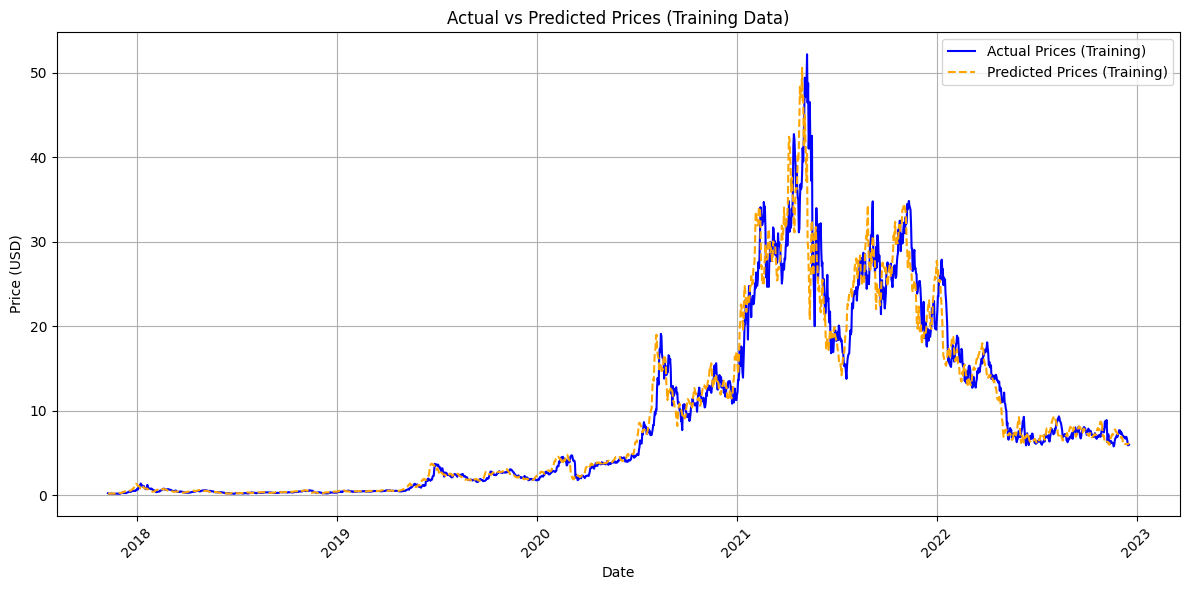

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(link_data.index[:train_size], link_data['Close'][:train_size], label='Actual Prices (Training)', color='blue')
plt.plot(link_data.index[:train_size][-len(y_train_pred_inv):], y_train_pred_inv, label='Predicted Prices (Training)', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

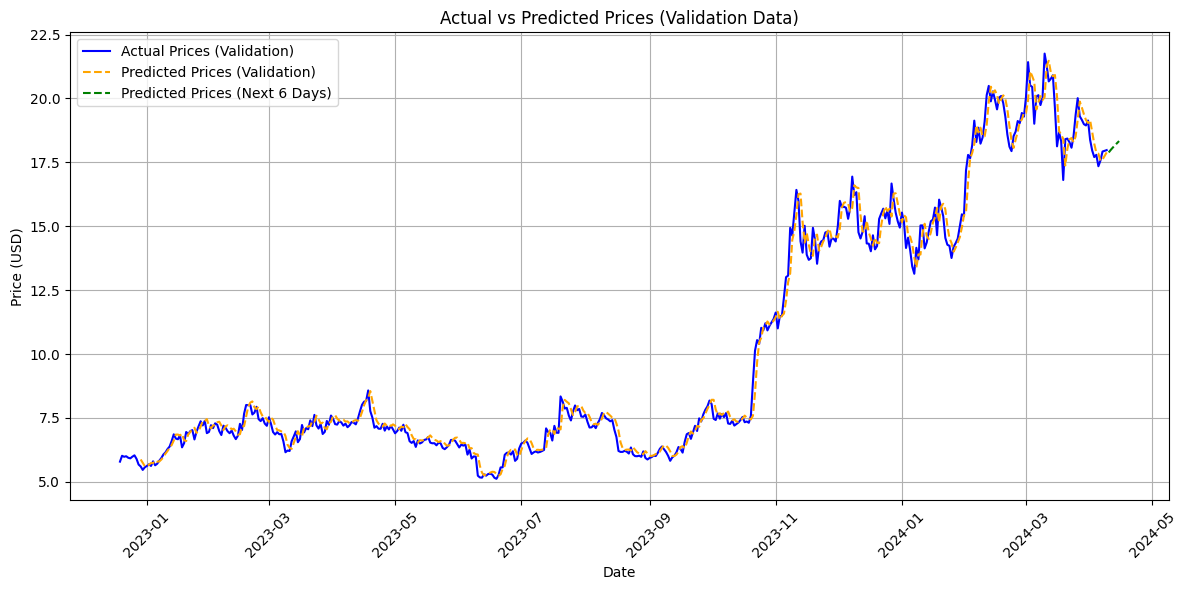

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(link_data.index[train_size:], link_data['Close'][train_size:], label='Actual Prices (Validation)', color='blue')
plt.plot(link_data.index[train_size:][-len(y_val_pred_inv):], y_val_pred_inv, label='Predicted Prices (Validation)', linestyle='dashed', color='orange')
predicted_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=6)
plt.plot(predicted_dates, predicted_prices, label='Predicted Prices (Next 6 Days)', linestyle='dashed', color='green')
plt.title('Actual vs Predicted Prices (Validation Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
last_date = link_data.index[-1]

next_six_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=6)

print("Predicted Prices for the Next:")
for i, (date, price) in enumerate(zip(next_six_days, predicted_prices), start=1):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]}")

Predicted Prices for the Next 6 Days (from March 16, 2024):
2024-04-10: 17.887802124023438 USD
2024-04-11: 17.988861083984375 USD
2024-04-12: 18.080625534057617 USD
2024-04-13: 18.166858673095703 USD
2024-04-14: 18.2503719329834 USD
2024-04-15: 18.332305908203125 USD


In [31]:
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 0.44571009019879726


In [33]:
model.save('stock_prediction.keras')